# Lecture 11 - Superconducting Josephson charge qubits

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import Qobj, about, plot_energy_levels, ket2dm, mesolve

%matplotlib inline

### Introduction

The Hamiltonian for a Josephson charge qubit is

$\displaystyle H = \sum_n 4 E_C (n_g - n)^2 \left|n\right\rangle\left\langle n\right| - \frac{1}{2}E_J\sum_n\left(\left|n+1\right\rangle\left\langle n\right| + \left|n\right\rangle\left\langle n+1\right| \right)$

where $E_C$ is the charge energy, $E_J$ is the Josephson energy, and $\left| n\right\rangle$ is the charge state with $n$ Cooper-pairs on the island that makes up the charge qubit.

#### References

 * [J. Koch et al, Phys. Rev. A 76, 042319 (2007)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.76.042319)
 * [Y.A. Pashkin et al, Quantum Inf Process 8, 55 (2009)](http://dx.doi.org/10.1007/s11128-009-0101-5)

### Helper functions

Below we will repeatedly need to obtain the charge qubit Hamiltonian for different parameters, and to plot the eigenenergies, so here we define two functions to do these tasks.

In [2]:
def hamiltonian(Ec, Ej, N, ng):
    """
    Return the charge qubit hamiltonian as a Qobj instance.
    """
    m = np.diag(4 * Ec * (np.arange(-N, N + 1) - ng) ** 2) + 0.5 * Ej * (
        np.diag(-np.ones(2 * N), 1) + np.diag(-np.ones(2 * N), -1)
    )
    return Qobj(m)

In [3]:
def plot_energies(ng_vec, energies, ymax=(20, 3)):
    """
    Plot energy levels as a function of bias parameter ng_vec.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for n in range(len(energies[0, :])):
        axes[0].plot(ng_vec, energies[:, n])
    axes[0].set_ylim(-2, ymax[0])
    axes[0].set_xlabel(r"$n_g$", fontsize=18)
    axes[0].set_ylabel(r"$E_n$", fontsize=18)

    for n in range(len(energies[0, :])):
        axes[1].plot(
            ng_vec,
            (energies[:, n] - energies[:, 0]) /
            (energies[:, 1] - energies[:, 0]),
        )
    axes[1].set_ylim(-0.1, ymax[1])
    axes[1].set_xlabel(r"$n_g$", fontsize=18)
    axes[1].set_ylabel(r"$(E_n-E_0)/(E_1-E_0)$", fontsize=18)
    return fig, axes

In [4]:
def visualize_dynamics(result, ylabel):
    """
    Plot the evolution of the expectation values stored in result.
    """
    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(result.times, result.expect[0])

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(r"$t$", fontsize=16);

### Charge qubit regime

In [5]:
N = 10
Ec = 1.0
Ej = 1.0

In [6]:
ng_vec = np.linspace(-4, 4, 200)

energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])

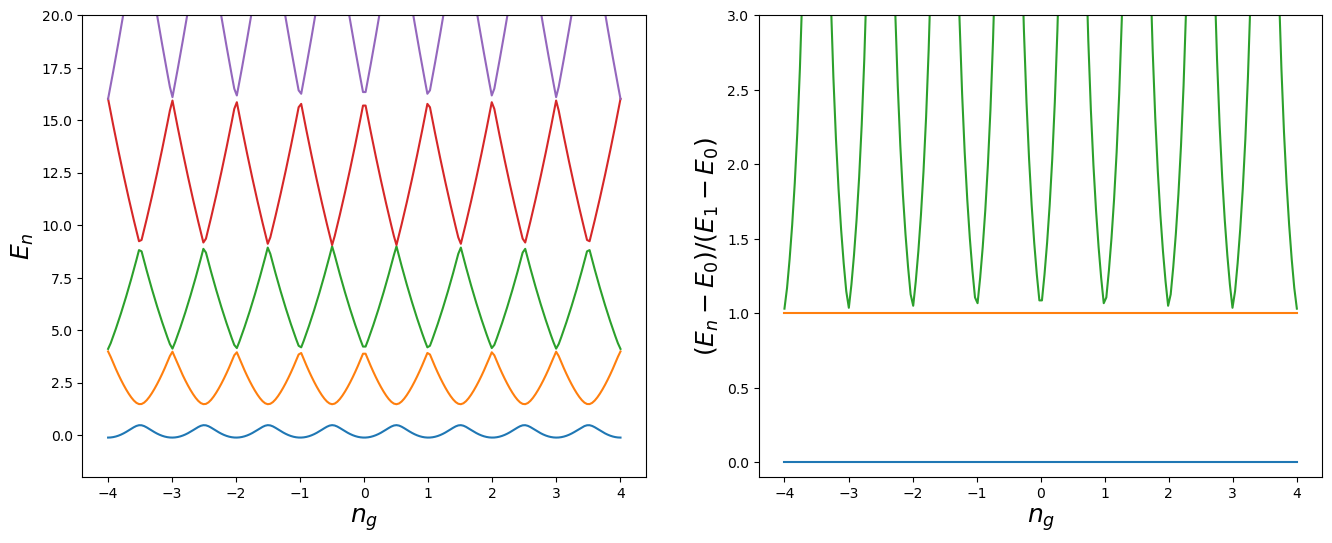

In [7]:
plot_energies(ng_vec, energies);

In [8]:
ng_vec = np.linspace(-1, 1, 200)

energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])

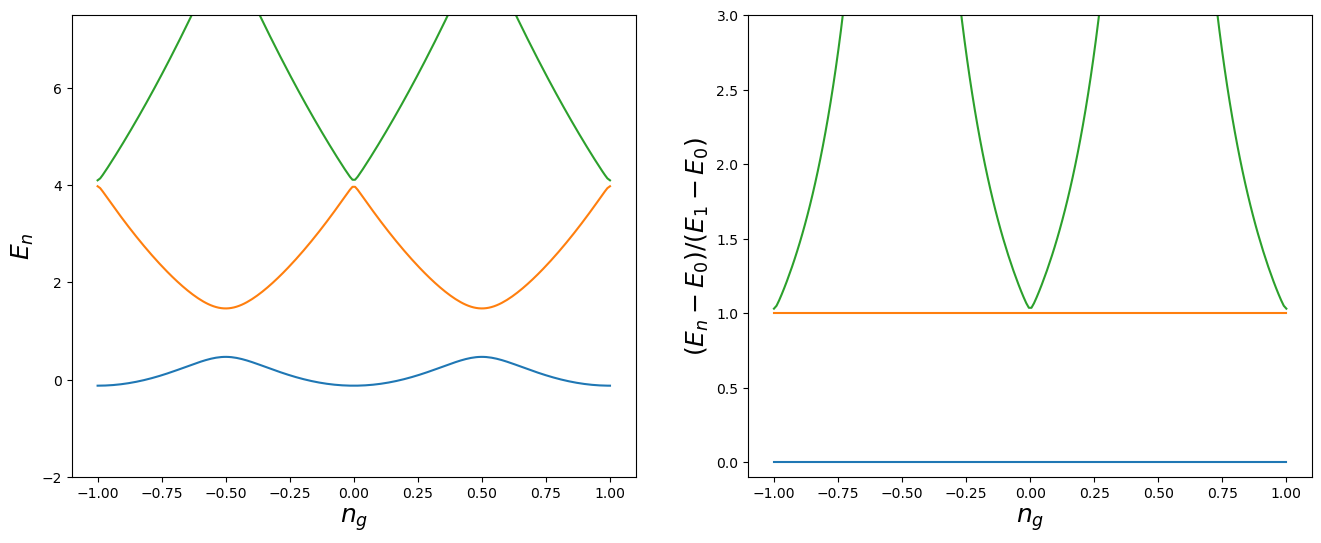

In [9]:
plot_energies(ng_vec, energies, ymax=(7.5, 3.0));

### Intermediate regime

In [10]:
ng_vec = np.linspace(-4, 4, 200)

In [11]:
Ec = 1.0
Ej = 5.0

In [12]:
energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])

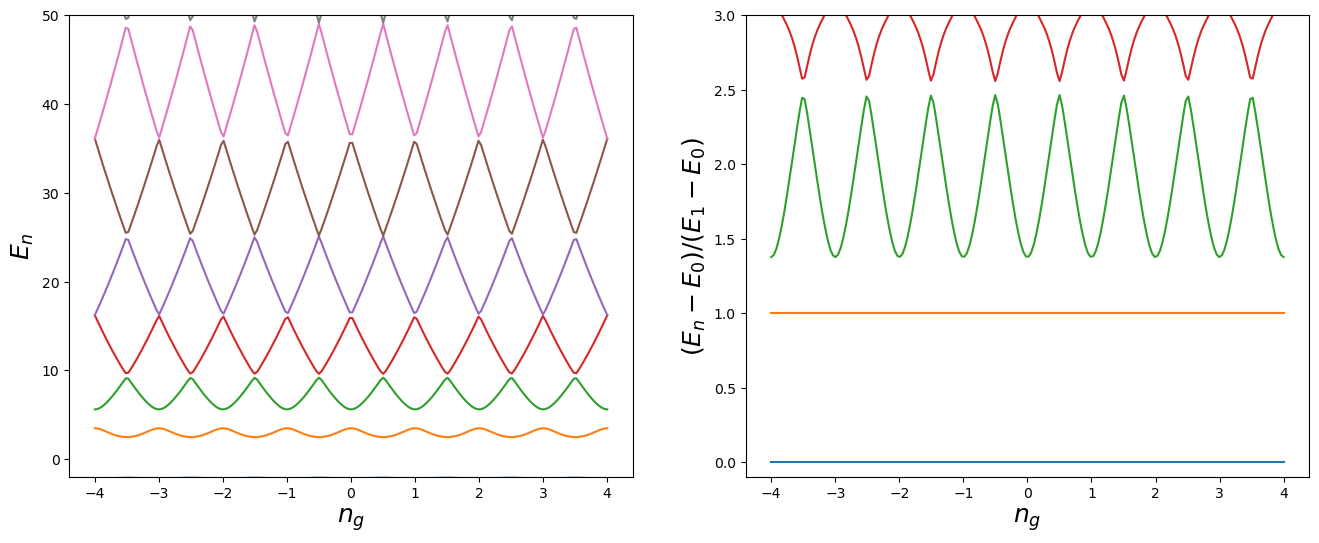

In [13]:
plot_energies(ng_vec, energies, ymax=(50, 3));

In [14]:
Ec = 1.0
Ej = 10.0

In [15]:
energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])

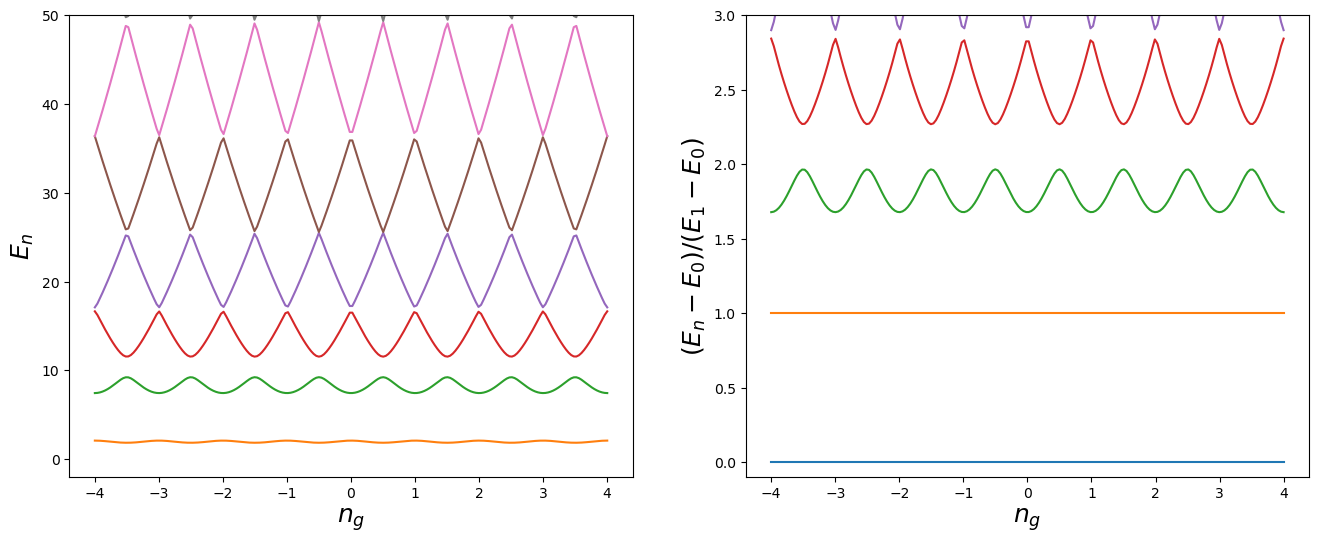

In [16]:
plot_energies(ng_vec, energies, ymax=(50, 3));

### Transmon regime

In [17]:
Ec = 1.0
Ej = 50.0

In [18]:
energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])

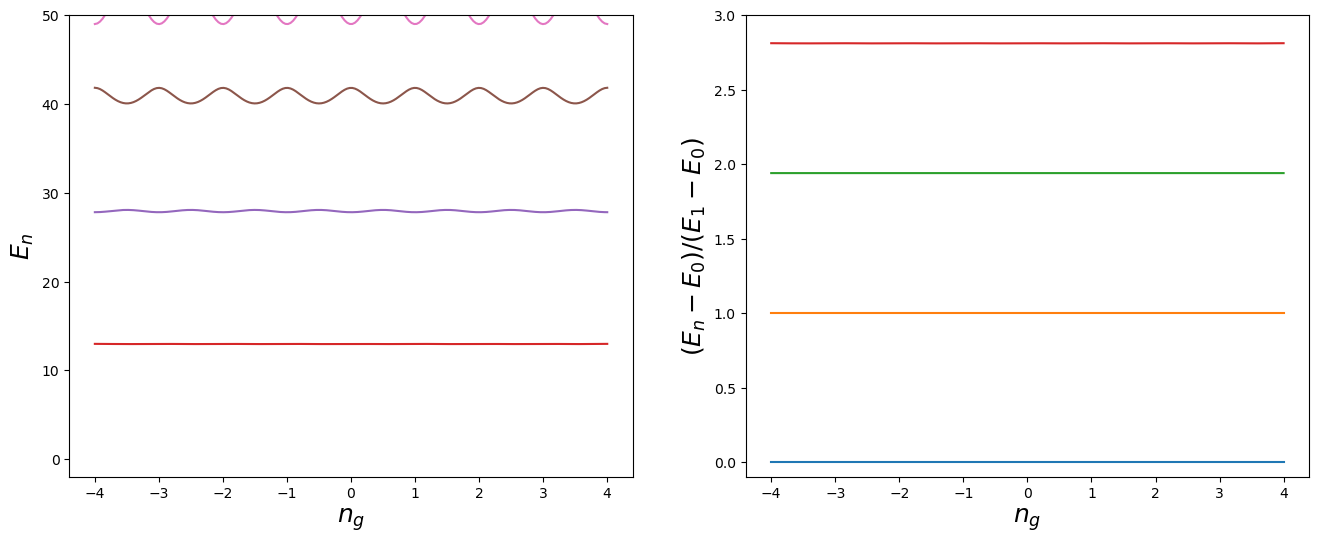

In [19]:
plot_energies(ng_vec, energies, ymax=(50, 3));

Note that the energy-level splitting is essentially independent of the gate bias $n_g$, at least for the lowest few states. This device is insensitive to charge noise. But at the same time the two lowest energy states are no longer well separated from higher states (it has become more like a harmonic oscillator). But some anharmonicity still remains, and it can still be used as a qubit if the leakage of occupation probability to the higher states can be kept under control.

## Focus on the two lowest energy states

Let's go back to the charge regime, and look at the lowest few energy levels again:

In [20]:
N = 10
Ec = 1.0
Ej = 1.0

In [21]:
ng_vec = np.linspace(-1, 1, 200)

In [22]:
energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])

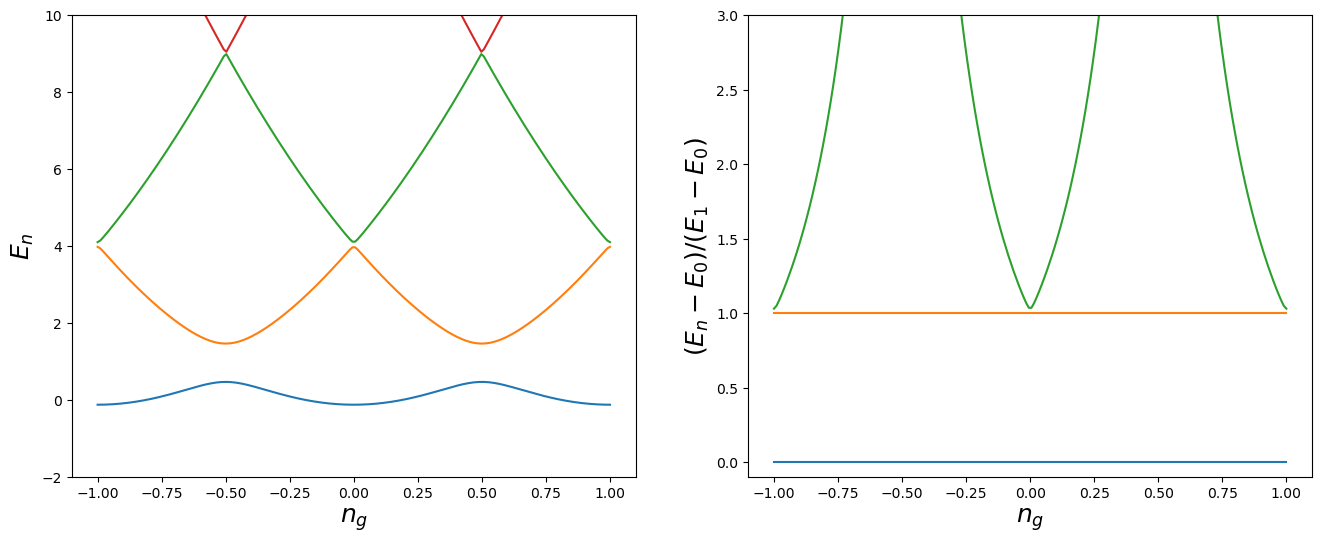

In [23]:
plot_energies(ng_vec, energies, ymax=(10, 3));

We can see that around $n_g = 0.5$ we have two lowest energy levels that are well separated for the higher energy levels:

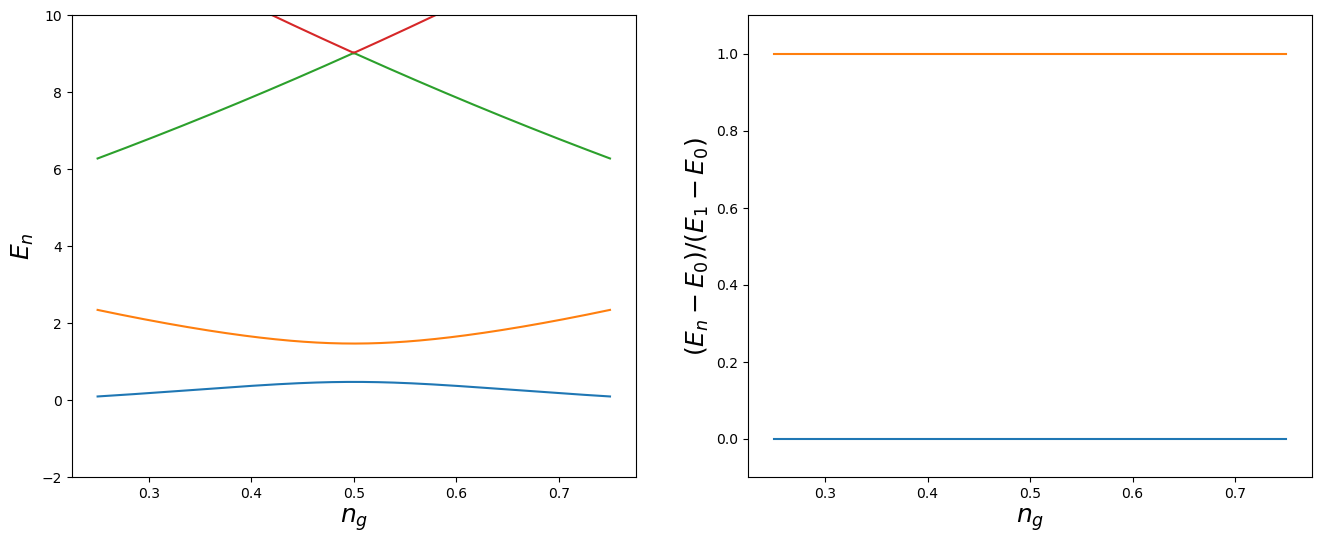

In [24]:
ng_vec = np.linspace(0.25, 0.75, 200)
energies = np.array([hamiltonian(Ec, Ej, N, ng).eigenenergies()
                     for ng in ng_vec])
plot_energies(ng_vec, energies, ymax=(10, 1.1));

Let's tune the system to $n_g = 0.5$ and look at the Hamiltonian and its eigenstates in detail

In [25]:
H = hamiltonian(Ec, Ej, N, 0.5)

In [26]:
H

Quantum object: dims=[[21], [21]], shape=(21, 21), type='oper', dtype=Dense, isherm=True
Qobj data =
[[441.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [ -0.5 361.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.   -0.5 289.   -0.5   0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.   -0.5 225.   -0.5   0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.   -0.5 169.   -0.5   0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.   -0.5 121.   -0.5   0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.   -0.5  81.   -0.5   0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    

In [27]:
evals, ekets = H.eigenstates()

The eigenenergies are sorted:

In [28]:
evals

array([  0.47065435,   1.46676684,   9.01371984,   9.01760693,
        25.00520901,  25.00520943,  49.00260427,  49.00260427,
        81.00156252,  81.00156252, 121.00104167, 121.00104167,
       169.00074405, 169.00074405, 225.00055804, 225.00055804,
       289.00043403, 289.00043411, 361.00034728, 361.00347214,
       441.00312494])

Only two states have a significant weight in the two lowest eigenstates:

In [29]:
ekets[0].full() > 0.1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

In [30]:
abs(ekets[1].full()) > 0.1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

We can use these two isolated eigenstates to define a qubit basis:

In [31]:
psi_g = ekets[0]  # basis(2, 0)
psi_e = ekets[1]  # basis(2, 1)

# psi_g = basis(2, 0)
# psi_e = basis(2, 1)

and corresponding Pauli matrices:

In [32]:
sx = psi_g * psi_e.dag() + psi_e * psi_g.dag()

In [33]:
sz = psi_g * psi_g.dag() - psi_e * psi_e.dag()

and an effective qubit Hamiltonian

In [34]:
evals[1] - evals[0]

np.float64(0.9961124875822172)

In [35]:
H0 = 0.5 * (evals[1] - evals[0]) * sz

A = 0.25  # some driving amplitude
Hd = 0.5 * A * sx  # obtained by driving ng(t),
# but now H0 is in the eigenbasis so the drive becomes a sigma_x

Doing this we have a bunch of extra energy levels in the system that aren't involved in the dynamics, but so far they are still in the Hamiltonian.

In [36]:
qubit_evals = H0.eigenenergies()

qubit_evals - qubit_evals[0]

array([0.        , 0.49805624, 0.49805624, 0.49805624, 0.49805624,
       0.49805624, 0.49805624, 0.49805624, 0.49805624, 0.49805624,
       0.49805624, 0.49805624, 0.49805624, 0.49805624, 0.49805624,
       0.49805624, 0.49805624, 0.49805624, 0.49805624, 0.49805624,
       0.99611249])

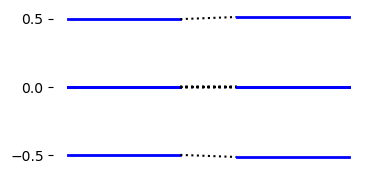

In [37]:
fig = plt.figure(figsize=(4, 2))
plot_energy_levels([H0, Hd], fig=fig);

Imagine that we also can drive a $\sigma_x$ type of interaction (e.g., external field):

In [38]:
Heff = [H0, [Hd, "sin(wd*t)"]]

args = {"wd": (evals[1] - evals[0])}

Let's look at the Rabi oscillation dynamics of the qubit when initially placed in the ground state:

In [39]:
psi0 = psi_g

In [40]:
tlist = np.linspace(0.0, 100.0, 500)
result = mesolve(Heff, psi0, tlist, [], e_ops=[ket2dm(psi_e)], args=args)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/coefficient.py:423: UserWarning: `cython`, `setuptools` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


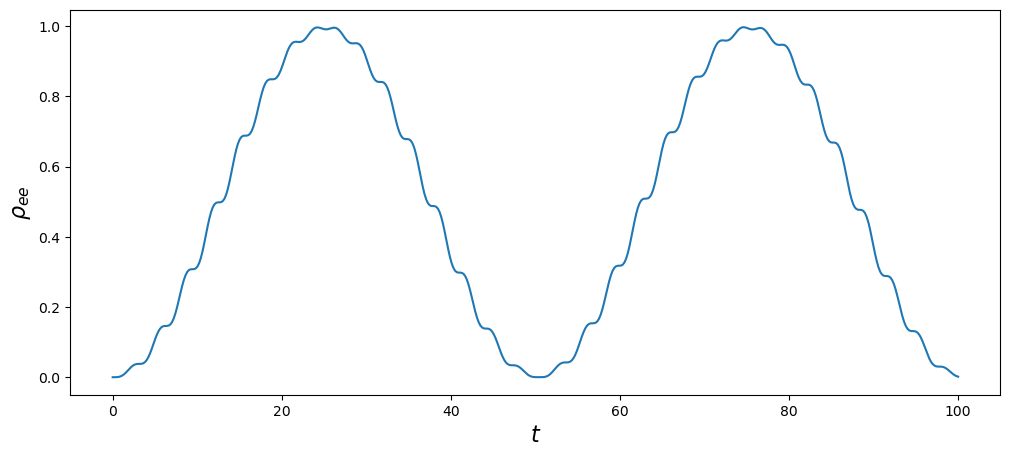

In [41]:
visualize_dynamics(result, r"$\rho_{ee}$");

We can see that only the two selected states are included in the dynamics, and very little leakage to other levels occur.

Instead of keeping all the inactive quantum states in the calculation we can eliminate them, so that we obtain a true two-level system.

In [42]:
np.where(abs(ekets[0].full().flatten()) > 0.1)[0]

array([10, 11])

In [43]:
np.where(abs(ekets[1].full().flatten()) > 0.1)[0]

array([10, 11])

In [44]:
keep_states = np.where(abs(ekets[1].full().flatten()) > 0.1)[0]

In [45]:
H0 = Qobj(H0.full()[keep_states, :][:, keep_states])

H0

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[2.40574436e-04 4.96105212e-01]
 [4.96105212e-01 2.40574436e-04]]

In [46]:
Hd = Qobj(Hd.full()[keep_states, :][:, keep_states])

Hd

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.24510324e-01 -1.04083409e-16]
 [-1.04083409e-16 -1.24510324e-01]]

And if we look at the energy level diagram now we see that we only have two states in the system, as desired.

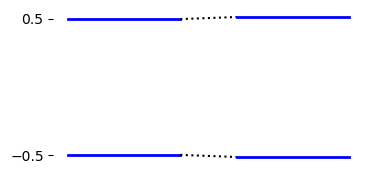

In [47]:
fig = plt.figure(figsize=(4, 2))
plot_energy_levels([H0, Hd], fig=fig);

In [48]:
Heff = [H0, [Hd, "sin(wd*t)"]]

args = {"wd": (evals[1] - evals[0])}

In [49]:
psi0 = Qobj(psi0.full()[keep_states, :])

In [50]:
psi_e = Qobj(psi_e.full()[keep_states, :])

In [51]:
tlist = np.linspace(0.0, 100.0, 500)
result = mesolve(Heff, psi0, tlist, [], e_ops=[ket2dm(psi_e)], args=args)

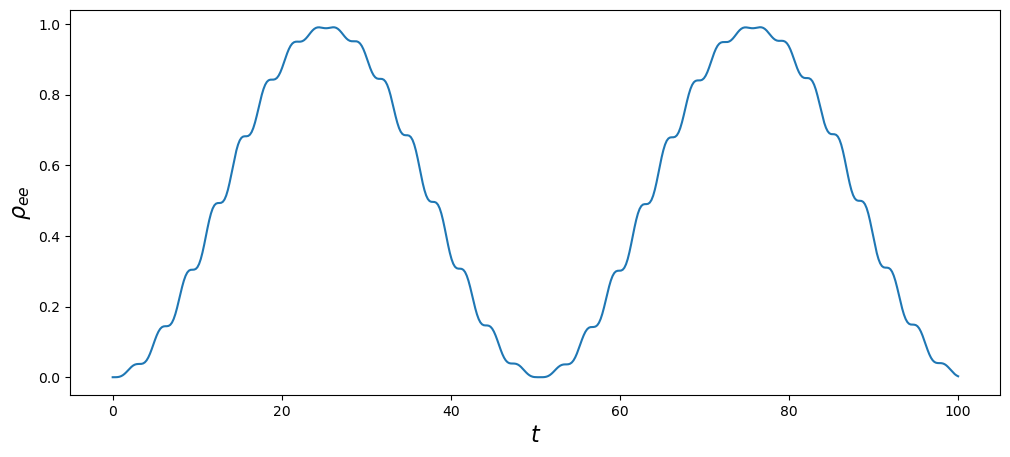

In [52]:
visualize_dynamics(result, r"$\rho_{ee}$");

### Software versions

In [53]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
